In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_json('train.json', lines=True)
test = pd.read_json('dev.json', lines=True)

### EDA

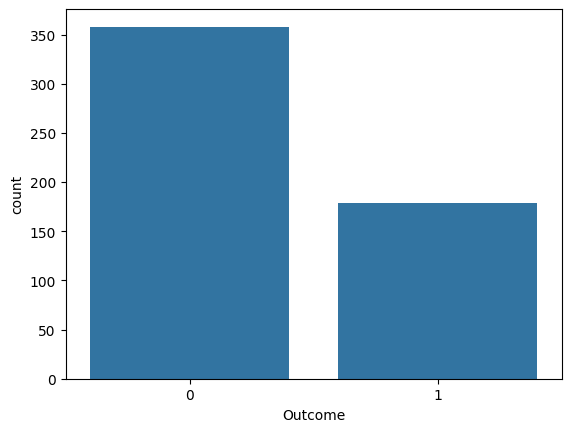

In [ ]:
sns.countplot(train, x='Outcome')
plt.show()

In [ ]:
train['Outcome'].value_counts()

0    358
1    179
Name: Outcome, dtype: int64

Có 358 dữ liệu nhãn 0 và 179 dữ liệu nhãn 1 ⇒ dữ liệu mất cân bằng nghiêng về phía 0 ⇒ có thể phải gắn trọng số nếu huấn luyện trên logistic regression.

In [ ]:
train.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.912477,119.581006,68.240223,20.536313,74.910615,31.829050,0.472933,33.335196,0.333333
std,3.399651,31.888470,19.806151,16.090900,105.687689,7.818561,0.317983,11.779668,0.471844
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.400000,0.245000,24.000000,0.000000
50%,3.000000,115.000000,70.000000,23.000000,0.000000,32.400000,0.382000,29.000000,0.000000
75%,6.000000,139.000000,78.000000,32.000000,125.000000,36.600000,0.619000,41.000000,1.000000
max,17.000000,199.000000,110.000000,99.000000,600.000000,55.000000,2.137000,72.000000,1.000000


5 cột Glucose, BloodPressure, SkinThickness, Insulin và BMI có min = 0 ⇒ có thể là placeholder của khuyết dữ liệu.

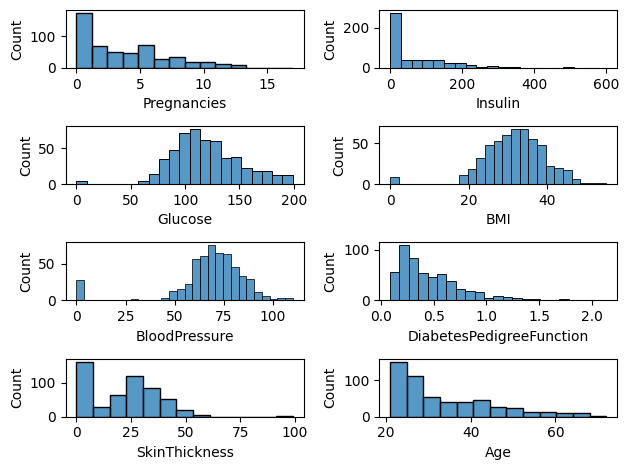

In [ ]:
fig, axes = plt.subplots(4, 2)

for idx, col in enumerate(train.columns[:-1]):
    idx_row = idx % 4
    idx_col = idx // 4
    sns.histplot(data=train, x=col, ax=axes[idx_row, idx_col])

fig.tight_layout()
plt.show()

Một số biểu đồ đặc trưng có cột giá trị 0 cao bất thường => 0 là placeholder của dữ liệu bị khuyết.

### Tiền xử lí dữ liệu

Thay thế giá trị bất thường bằng np.nan

In [ ]:
train[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = train[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
test[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = test[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

Tạo một mô hình tiền xử lí dữ liệu mới, fit lên tập train

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

transformer = ColumnTransformer([
    ("mean_imputer", SimpleImputer(strategy='mean'), ['Pregnancies','Glucose','BloodPressure','SkinThickness','BMI', 'Age']),
    ("median_imputer", SimpleImputer(strategy='median'), ['Insulin','DiabetesPedigreeFunction']),
    ("skip", "passthrough", ["Outcome"])
])

transformer.fit(train)

ColumnTransformer(transformers=[('mean_imputer', SimpleImputer(),
                                 ['Pregnancies', 'Glucose', 'BloodPressure',
                                  'SkinThickness', 'BMI', 'Age']),
                                ('median_imputer',
                                 SimpleImputer(strategy='median'),
                                 ['Insulin', 'DiabetesPedigreeFunction']),
                                ('skip', 'passthrough', ['Outcome'])])

Điền các giá trị bị thiếu

In [ ]:
train = pd.DataFrame(transformer.transform(train.copy(deep=True)), index=train.index,
                     columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','BMI', 'Age',
                              'Insulin','DiabetesPedigreeFunction',"Outcome"])
train

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,Age,Insulin,DiabetesPedigreeFunction,Outcome
0,1.0,80.0,55.0,29.329787,19.1,21.0,125.0,0.258,0.0
1,1.0,124.0,74.0,36.000000,27.8,30.0,125.0,0.100,0.0
2,10.0,108.0,66.0,29.329787,32.4,42.0,125.0,0.272,1.0
3,2.0,120.0,76.0,37.000000,39.7,29.0,105.0,0.215,0.0
4,11.0,136.0,84.0,35.000000,28.3,42.0,130.0,0.260,1.0
...,...,...,...,...,...,...,...,...,...
532,4.0,127.0,88.0,11.000000,34.5,28.0,155.0,0.598,0.0
533,1.0,90.0,68.0,8.000000,24.5,36.0,125.0,1.138,0.0
534,8.0,120.0,78.0,29.329787,25.0,64.0,125.0,0.409,0.0
535,3.0,106.0,54.0,21.000000,30.9,24.0,158.0,0.292,0.0


In [ ]:
test = pd.DataFrame(transformer.transform(test.copy(deep=True)), index=test.index,
                     columns=['Pregnancies','Glucose','BloodPressure','SkinThickness','BMI', 'Age',
                              'Insulin','DiabetesPedigreeFunction',"Outcome"])

### Feature selection & engineering

##### Phân tích mức ảnh hưởng mỗi đặc trưng lên kết quả

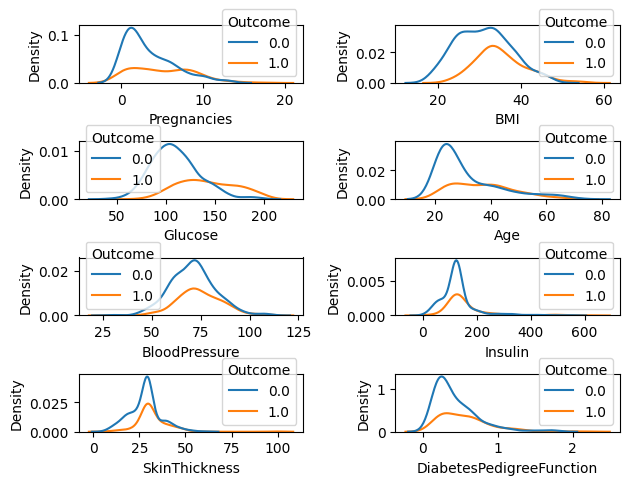

In [ ]:
fig, axes = plt.subplots(4, 2)

for idx, col in enumerate(train.columns[:-1]):
    idx_row = idx % 4
    idx_col = idx // 4
    sns.kdeplot(data=train, x=col, hue='Outcome', ax=axes[idx_row, idx_col])

fig.tight_layout()
plt.show()

Các đặc trưng có ảnh hưởng nhất là Glucose, Age và BMI.

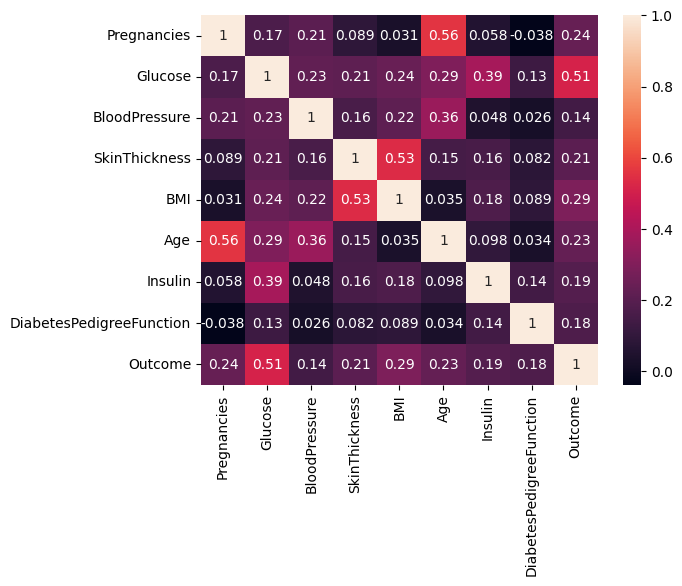

In [ ]:
sns.heatmap(train.corr(), annot=True)
plt.show()

Các đặc trưng không có tương quan tuyến tính với nhau quá mạnh ⇒ có thể chọn hết các đặc trưng.

##### Thiết kế các đặc trưng mới

Chuyển đặc trưng Glucose thành đặc trưng phân loại giữa mức Glucose cao và mức Glucose thấp

In [ ]:
new_feature = pd.cut(train['Glucose'], [0, 120.0, pd.Series.max(train['Glucose'])], right=True, labels=['Normal', 'High'])
train.insert(len(train.columns) - 1, "GlucoseType", value=new_feature)
train.drop("Glucose", axis="columns", inplace=True)

new_feature = pd.cut(test['Glucose'], [0, 120.0, pd.Series.max(test['Glucose'])], right=True, labels=['Normal', 'High'])
test.insert(len(test.columns) - 1, "GlucoseType", value=new_feature)
test.drop("Glucose", axis="columns", inplace=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = ColumnTransformer(
    [('encoder', OrdinalEncoder(), ['GlucoseType'])]
)

encoder.fit(train)

ColumnTransformer(transformers=[('encoder', OrdinalEncoder(), ['GlucoseType'])])

In [ ]:
train['GlucoseType'] = encoder.transform(train)
test['GlucoseType'] = encoder.transform(test)

Chuyển đặc trưng BMI thành đặc trưng phân loại người bình thường và những người béo phì

In [ ]:
new_feature = pd.cut(train['BMI'], [0, 25, 35, train['BMI'].max()], labels=['Normal', 'ObeseTypeI', 'ObeseTypeII'])
train.insert(len(train.columns), "BMIType", value=new_feature)
train.drop("BMI", axis="columns", inplace=True)

new_feature = pd.cut(test['BMI'], [0, 25, 35, test['BMI'].max()], labels=['Normal', 'ObeseTypeI', 'ObeseTypeII'])
test.insert(len(test.columns), "BMIType", value=new_feature)
test.drop("BMI", axis="columns", inplace=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), ["BMIType"])]
)

encoder.fit(train)

ColumnTransformer(transformers=[('one_hot_encoder', OneHotEncoder(),
                                 ['BMIType'])])

In [ ]:
onehot_feature = pd.DataFrame(encoder.transform(train), columns=["BMIType_Normal", "BMIType_ObeseTypeI", "BMIType_ObeseTypeII"])
train = pd.concat([train, onehot_feature], axis="columns")
train.drop("BMIType", axis="columns", inplace=True)

In [ ]:
onehot_feature = pd.DataFrame(encoder.transform(test), columns=["BMIType_Normal", "BMIType_ObeseTypeI", "BMIType_ObeseTypeII"])
test = pd.concat([test, onehot_feature], axis="columns")
test.drop("BMIType", axis="columns", inplace=True)

Chuyển đặc trưng "số tuổi" thành đặc trưng loại độ tuổi: trẻ, trưởng thành và trung niên trở về sau

In [ ]:
new_feature = pd.cut(train['Age'], [0, 25, 35, train['Age'].max()], labels=['young', 'mature', 'senior'])
train.insert(len(train.columns), "AgeType", value=new_feature)
train.drop("Age", axis="columns", inplace=True)

new_feature = pd.cut(test['Age'], [0, 25, 35, test['Age'].max()], labels=['young', 'mature', 'senior'])
test.insert(len(test.columns), "AgeType", value=new_feature)
test.drop("Age", axis="columns", inplace=True)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = ColumnTransformer(
    [('encoder', OneHotEncoder(), ['AgeType'])]
)

encoder.fit(train)

onehot_feature = pd.DataFrame(encoder.transform(train), columns=["AgeType_Young", "AgeType_Mature", "AgeType_Senior"])
train = pd.concat([train, onehot_feature], axis="columns")
train.drop("AgeType", axis="columns", inplace=True)

onehot_feature = pd.DataFrame(encoder.transform(test), columns=["AgeType_Young", "AgeType_Mature", "AgeType_Senior"])
test = pd.concat([test, onehot_feature], axis="columns")
test.drop("AgeType", axis="columns", inplace=True)

In [ ]:
train

,Pregnancies,BloodPressure,SkinThickness,BMI,Insulin,DiabetesPedigreeFunction,GlucoseType,Outcome,AgeType_Young,AgeType_Mature,AgeType_Senior
0,1.0,55.0,29.329787,19.1,125.0,0.258,1.0,0.0,0.0,0.0,1.0
1,1.0,74.0,36.000000,27.8,125.0,0.100,0.0,0.0,1.0,0.0,0.0
2,10.0,66.0,29.329787,32.4,125.0,0.272,1.0,1.0,0.0,1.0,0.0
3,2.0,76.0,37.000000,39.7,105.0,0.215,1.0,0.0,1.0,0.0,0.0
4,11.0,84.0,35.000000,28.3,130.0,0.260,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
532,4.0,88.0,11.000000,34.5,155.0,0.598,0.0,0.0,1.0,0.0,0.0
533,1.0,68.0,8.000000,24.5,125.0,1.138,1.0,0.0,0.0,1.0,0.0
534,8.0,78.0,29.329787,25.0,125.0,0.409,1.0,0.0,0.0,1.0,0.0
535,3.0,54.0,21.000000,30.9,158.0,0.292,1.0,0.0,0.0,0.0,1.0


### Model selection & hyperparameter tuning

In [ ]:
X_train = train.drop("Outcome", axis=1)
y_train = train["Outcome"]

In [ ]:
X_test = test.drop("Outcome", axis=1)
y_test = test["Outcome"]

In [ ]:
X_train.describe()

,Pregnancies,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,GlucoseType,AgeType_Young,AgeType_Mature,AgeType_Senior,BMIType_Normal,BMIType_ObeseTypeI,BMIType_ObeseTypeII
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.00000
mean,3.912477,71.994106,29.329787,137.527002,0.472933,0.558659,0.292365,0.359404,0.348231,0.152700,0.525140,0.32216
std,3.399651,11.646454,8.831455,75.396587,0.317983,0.497010,0.455273,0.480273,0.476854,0.360034,0.499833,0.46774
min,0.000000,30.000000,7.000000,15.000000,0.084000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,64.000000,25.000000,125.000000,0.245000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,3.000000,71.994106,29.329787,125.000000,0.382000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,6.000000,78.000000,32.000000,125.000000,0.619000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000
max,17.000000,110.000000,99.000000,600.000000,2.137000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


**TODO:**

- Viết hàm model selection giữa các mô hình: Logistic Regression, K-nearest Neighbors (`sklearn.neighbors.KNeighborsClassifier`), Stochastic Gradient Descent (`sklearn.linear_model.SGDClassifier`), Random Forest (`sklearn.ensemble.RandomForestClassifier`), Support Vector Machine (`sklearn.svm.SVC`), Decision Tree (`sklearn.tree.DecisionTreeClassifier`).
- Với các model có `random_state`, chọn `random_state=42`.
- Chọn ra các model có điểm F1 trên tập test > 0.81 để thực hiện chọn siêu tham số.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = [
    ("Logistic Regression", LogisticRegression()),
    ("KNN", KNeighborsClassifier()),
    ("SGD", SGDClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("Support Vector Machine", SVC(random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("XGBoost", XGBClassifier(random_state=42)),
    ("AdaBoost", AdaBoostClassifier(random_state=42)),
    ("LightGBM", LGBMClassifier(random_state=42))
]

result = []

for model in models:
    model[1].fit(X_train, y_train)
    y_pred = model[1].predict(X_test)
    result.append((model[0], f1_score(y_test, y_pred)))

result_df = pd.DataFrame(result, columns=['Model', 'F1 score'])
result_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 179, number of negative: 358
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 358
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,Model,F1 score
0,Logistic Regression,0.655172
1,KNN,0.526316
2,SGD,0.622951
3,Random Forest,0.603175
4,Support Vector Machine,0.153846
5,Decision Tree,0.539683
6,XGBoost,0.612903
7,AdaBoost,0.634921
8,LightGBM,0.566667


Chọn Logistic Regression, SGD, Random Forest, Decision Tree, LightGBM

In [ ]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(class_weight='balanced')
search_space = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear', 'lbfgs']}

GS = GridSearchCV(estimator=lr, param_grid=search_space, scoring='f1')
GS.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'solver': ['liblinear', 'lbfgs']},
             scoring='f1')

In [ ]:
GS.best_estimator_

LogisticRegression(C=0.08858667904100823, class_weight='balanced',
                   solver='liblinear')

In [ ]:
y_pred = GS.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        41
         1.0       0.76      0.89      0.82        36

    accuracy                           0.82        77
   macro avg       0.82      0.82      0.82        77
weighted avg       0.83      0.82      0.82        77



In [ ]:
f1_score(y_test, y_pred)

0.8205128205128205

In [ ]:
sgd = SGDClassifier(random_state=42, class_weight='balanced')
search_space = {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron'],
                'eta0': [0.1, 0.05, 0.01, 0.005, 0.001],
                'max_iter': [1000, 5000]}

GS = GridSearchCV(estimator=sgd, param_grid=search_space, scoring='f1')
GS.fit(X_train, y_train)

GridSearchCV(estimator=SGDClassifier(class_weight='balanced', random_state=42),
             param_grid={'eta0': [0.1, 0.05, 0.01, 0.005, 0.001],
                         'loss': ['hinge', 'log_loss', 'modified_huber',
                                  'squared_hinge', 'perceptron'],
                         'max_iter': [1000, 5000]},
             scoring='f1')

In [ ]:
GS.best_estimator_

SGDClassifier(class_weight='balanced', eta0=0.1, loss='squared_hinge',
              random_state=42)

In [ ]:
y_pred = GS.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.88      0.75        41
         1.0       0.77      0.47      0.59        36

    accuracy                           0.69        77
   macro avg       0.71      0.68      0.67        77
weighted avg       0.71      0.69      0.67        77



In [ ]:
f1_score(y_test, y_pred)

0.5862068965517242

In [ ]:
ada_boost = AdaBoostClassifier()
search_space = {
    "n_estimators": [50, 100],
    "learning_rate": [1, 0.1, 0.01, 0.001],
    "estimator": [DecisionTreeClassifier(max_depth=1), LogisticRegression(), SGDClassifier()]
}

GS = GridSearchCV(estimator=ada_boost, param_grid=search_space, scoring='f1')
GS.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'estimator': [DecisionTreeClassifier(max_depth=1),
                                       LogisticRegression(), SGDClassifier()],
                         'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [50, 100]},
             scoring='f1')

In [ ]:
GS.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01)

In [ ]:
y_pred = GS.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76        41
         1.0       0.72      0.72      0.72        36

    accuracy                           0.74        77
   macro avg       0.74      0.74      0.74        77
weighted avg       0.74      0.74      0.74        77



In [ ]:
f1_score(y_test, y_pred)

0.7222222222222222